In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


In [44]:
data = pd.read_csv('UCI_Credit_Card.csv')
data.drop(['ID'], axis=1, inplace=True)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [45]:
# Sanity Checks - Conform whether no string column present and no null value present
data.isnull().sum()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [46]:
### Seperate features and target variable
X= data.drop('default.payment.next.month', axis=1)
y= data['default.payment.next.month']

In [47]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (30000, 23)
y shape: (30000,)


ANN gradient descent pe kaam karta hai, aur agar features ka scale alag-alag ho to gradients unstable ho jaate hain, isliye scaling zaroori hoti hai.

In [48]:
### Train–Validation–Test Split
from sklearn.model_selection import train_test_split 

# First split: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Second split: Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

### Now do the Feature Scaling
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Create Logistic Regresion model before Actual Ann Model ?

I trained a simple model first to ensure the data pipeline works and to have a baseline for comparison before building a complex ANN.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

log_model.fit(X_train_scaled, y_train)
y_test_prob_lr = log_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_lr = (y_test_prob_lr >= 0.5).astype(int)


In [50]:
print("Logistic Regression ROC-AUC:",
      roc_auc_score(y_test, y_test_prob_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_lr))


Logistic Regression ROC-AUC: 0.7182004272798959
Confusion Matrix:
[[2453 1051]
 [ 366  630]]


In [51]:
### ANN BUILD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)), #HL1
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'), ## HL2
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid') ##Output layer

])



c:\Users\onlyy\OneDrive\Documents\GenAI_ANN_Project2\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 192 (768.00 B)

Why:

1.  Optimizer → Adam, fast convergence

2.  Loss → binary_crossentropy, kyunki 0/1 prediction

3.  Metric → AUC, imbalanced class ke liye better than accuracy

In [53]:
## To do forward and backward propogation we need to compile the model 
model.compile(optimizer="adam" , loss = "binary_crossentropy" , metrics=['accuracy'] ) ## if it is multiclass then it is sparse_crossentropy.

In [54]:
class_weight = {0: 1, 1: 3}  # Default class 3x weight


In [55]:
## Set up the Tensorboard
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping 
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  ## when we train our model all logs will be saved in this folder
tensorflow_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)  ## we can use matabolib insted of histogram freq=1


In [56]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [57]:
### Train the model
history = model.fit(
    X_train_scaled,y_train,
    validation_data = (X_val_scaled, y_val),
    epochs=100, 
    class_weight=class_weight,
    callbacks=[early_stop, tensorflow_callback]
)

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6366 - loss: 1.0595 - val_accuracy: 0.7844 - val_loss: 0.5729
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7347 - loss: 0.8948 - val_accuracy: 0.7978 - val_loss: 0.5531
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7608 - loss: 0.8630 - val_accuracy: 0.7958 - val_loss: 0.5447
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7660 - loss: 0.8524 - val_accuracy: 0.7882 - val_loss: 0.5492
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7736 - loss: 0.8459 - val_accuracy: 0.7882 - val_loss: 0.5442
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7690 - loss: 0.8422 - val_accuracy: 0.7858 - val_loss: 0.5362
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7717 - loss: 0.8413 - val_accuracy: 0.7787 - val_loss: 0.5392
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7679 - loss: 0.8348 - val_accu

In [58]:
model.save('model.h5') ### Save the trained model

In [59]:
### Load the trained model
from tensorflow.keras.models import load_model
model = load_model('model.h5')
### Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.7711 - loss: 226.1548
Test Loss: 226.15475463867188
Test Accuracy: 0.7711111307144165


The above code is sufficent but as bank project is a risky project so wee need probability predection rather than just accuracy.ROC-AUC AND THRESOLD CONTROL SO WE WILL DO IT IN NEXT FILE

In [60]:
from sklearn.metrics import roc_auc_score
## Probability predictions and class predictions
y_test_prob_ann = model.predict(X_test_scaled).ravel()
y_test_pred_ann = (y_test_prob_ann >= 0.5).astype(int)


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


In [61]:
# Probability scores from Logistic Regression
y_test_prob_lr = log_model.predict_proba(X_test_scaled)[:, 1]

# ROC-AUC score
from sklearn.metrics import roc_auc_score
roc_auc_lr = roc_auc_score(y_test, y_test_prob_lr)

print("Logistic Regression ROC-AUC:", roc_auc_lr)


Logistic Regression ROC-AUC: 0.7182004272798959


In [62]:
print(f"Logistic Regression ROC-AUC: {roc_auc_lr:.4f}")
print("ANN ROC-AUC:",
      roc_auc_score(y_test, y_test_prob_ann))

## ANN BETTER THEN LOGISTIC REGRESSION MODEL GOOD


Logistic Regression ROC-AUC: 0.7182
ANN ROC-AUC: 0.7758283419064385


In [63]:
## Confusion Matrix for ANN
from sklearn.metrics import confusion_matrix

cm_ann = confusion_matrix(y_test, y_test_pred_ann)
print("Confusion Matrix:\n", cm_ann)


Confusion Matrix:
 [[2929  575]
 [ 423  573]]


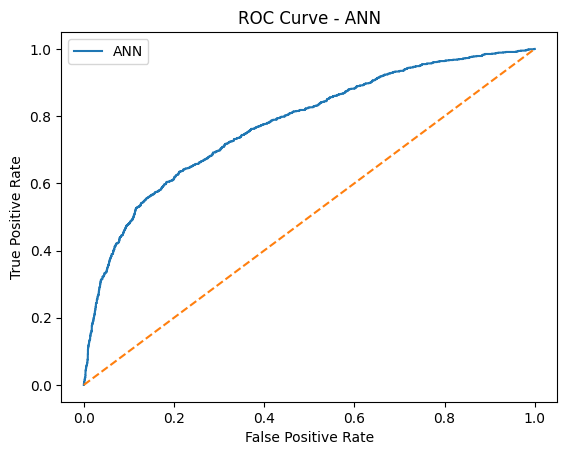

In [64]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_test_prob_ann)

plt.plot(fpr, tpr, label="ANN")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ANN")
plt.legend()
plt.show()


### THESE ABOVE CELLS ARE GOOD FOR MODEL BUILDING AND EVALUATION ###

In [66]:
## Logistic regression was previosly use by banks we have made ann model if it will perform better than it then we can suggest to use ann model for credit card default prediction.
### Logistic Regression was used as a baseline model. ANN was adopted to capture non-linear relationships. ROC-AUC was chosen due to class imbalance and business relevance in credit risk modeling.

In [42]:
### Feature is saved to save the feature names for future reference as ann does not understand feature names only positions 
feature_names = X.columns.tolist()

with open("features.pkl", "wb") as f:
    pickle.dump(feature_names, f)

In [67]:
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
